In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


In [ ]:
# Load the dataset
file_path = "weather.csv"  # Update with the correct path
df = pd.read_csv(file_path)

# Convert Date/Time to datetime and sort
df["Date/Time (LST)"] = pd.to_datetime(df["Date/Time (LST)"])
df = df.sort_values(by="Date/Time (LST)").reset_index(drop=True)

# Normalize numerical features
num_features = [
    "Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Wind Dir (10s deg)",
    "Wind Spd (km/h)", "Visibility (km)", "Stn Press (kPa)", "Hmdx", "Wind Chill", "temp change"
]
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Create sequences
SEQ_LENGTH = min(6, len(df) -1)  # Use 6 past hours to predict the next hour
feature_columns = df.columns.difference(["Date/Time (LST)", "temp change"]).tolist()

seq_data = df[feature_columns].to_numpy()
target_data = df["temp change"].to_numpy()

# Generate rolling sequences
X = np.lib.stride_tricks.sliding_window_view(seq_data, (SEQ_LENGTH, seq_data.shape[1])).squeeze(axis=1)
y = target_data[SEQ_LENGTH:]

# Time-Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
splits = [(train_idx, val_idx) for train_idx, val_idx in tscv.split(X)]



def train_gru(build_rnn_model):
    adjusted_splits = [(train_idx[train_idx < len(y)], val_idx[val_idx < len(y)]) for train_idx, val_idx in splits]
    # Train and evaluate using time-series cross-validation
    history_list = []
    for fold, (train_idx, val_idx) in enumerate(adjusted_splits):
        if len(train_idx) == 0 or len(val_idx) == 0:
            print(f"Skipping fold {fold +1}: index out of bound")
            continue
        else:
            print(f"Training on fold {fold + 1}...")

        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Build and train model
        model = build_rnn_model((SEQ_LENGTH, X.shape[2]))
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=10, batch_size=32, verbose=1)
        
        # Save training history
        history_list.append(history)

    # Plot Training Loss
    plt.figure(figsize=(10, 5))
    for i, history in enumerate(history_list):
        plt.plot(history.history["loss"], label=f"Train Loss Fold {i+1}")
        plt.plot(history.history["val_loss"], label=f"Val Loss Fold {i+1}")

    plt.title("Training & Validation Loss Across Folds")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

## GRU models to be tested

In [ ]:

from tensorflow.keras.layers import Bidirectional
# baseline model to compare future models against

def build_basic_rnn_model(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True),  # First GRU layer
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# stacked GRU layers allow the model to capture more complex patterns by
# processing the sequential data through multiple GRU layers. The output of each layer is passed as 
# input to the next layer, which allows the model to learn different levels of abstractions.

def build_stacked_rnn_model(input_shape):
    model = Sequential([
        GRU(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        GRU(64, activation='tanh'),
        Dense(1)  # For regression (single output)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Bidirectional GRUs process the input sequence in both forward and backward directions. This is useful for
# sequential data where both past and future context can help improve predictions 
# (e.g., weather data where past trends and future shifts are important).

def build_bidirectional_rnn_model(input_shape):
    model = Sequential([
        Bidirectional(GRU(64, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


# Adding dropout and recurrent dropout helps prevent overfitting, especially in more complex models. 
# Dropout is applied to the input, while recurrent dropout is applied to the recurrent connections (feedback loops between layers).

def build_dropout_rnn_model(input_shape):
    model = Sequential([
        GRU(128, activation='tanh', return_sequences=True, 
               dropout=0.3, recurrent_dropout=0.3, input_shape=input_shape),
        GRU(64, activation='tanh', dropout=0.3, recurrent_dropout=0.3),
        Dense(1)        
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Attention mechanisms help the model focus on specific parts of the sequence that are most important for making predictions. 
# In the case of weather prediction, the model might focus more on specific times (e.g., early morning or evening) 
# when the weather patterns change more dramat

def build_attention_rnn_model(input_shape):
    model = Sequential([
        GRU(128, activation='tanh', return_sequences=True, 
               dropout=0.3, recurrent_dropout=0.3, input_shape=input_shape),
        GRU(64, activation='tanh', dropout=0.3, recurrent_dropout=0.3),
        Dense(1)        
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

## Training GRU models

### Baseline

Training on fold 1...
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0079 - mae: 0.0639 - val_loss: 0.0056 - val_mae: 0.0545
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - mae: 0.0557 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - mae: 0.0551 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - mae: 0.0561 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - mae: 0.0560 - val_loss: 0.0055 - val_mae: 0.0537
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - mae: 0.0560 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - mae: 0.0554 - val_loss: 0.0054 - val_mae: 0.0529
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - mae: 0.0556 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 9/10
532/532 ━━━━━━━━━━━━━━━

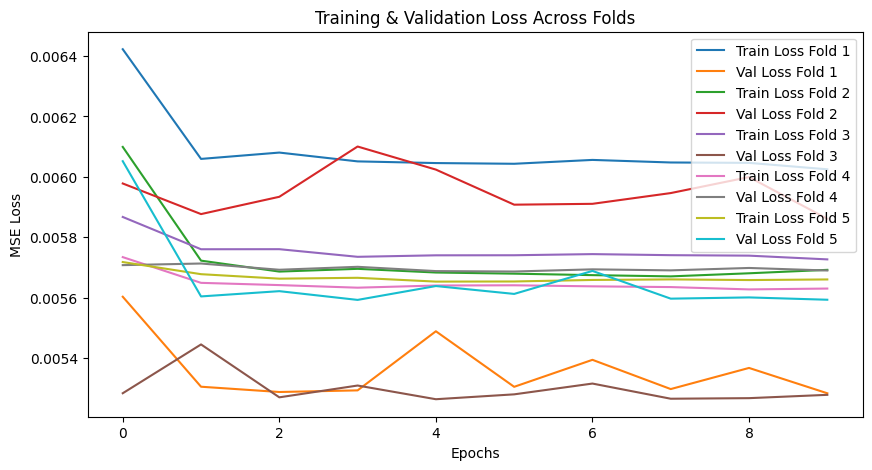

In [9]:
train_gru(build_basic_rnn_model)


### Stacked

Training on fold 1...
Epoch 1/10


c:\Users\graem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0167 - mae: 0.0864 - val_loss: 0.0053 - val_mae: 0.0538
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0061 - mae: 0.0583 - val_loss: 0.0048 - val_mae: 0.0505
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0060 - mae: 0.0569 - val_loss: 0.0050 - val_mae: 0.0512
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0061 - mae: 0.0574 - val_loss: 0.0061 - val_mae: 0.0609
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0056 - mae: 0.0550 - val_loss: 0.0070 - val_mae: 0.0653
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0057 - mae: 0.0556 - val_loss: 0.0053 - val_mae: 0.0537
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0054 - mae: 0.0534 - val_loss: 0.0047 - val_mae: 0.0507
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0054 - mae: 0.0543 - val_loss: 0.0048 - val_mae: 0.0504
Epoch 9/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0055 

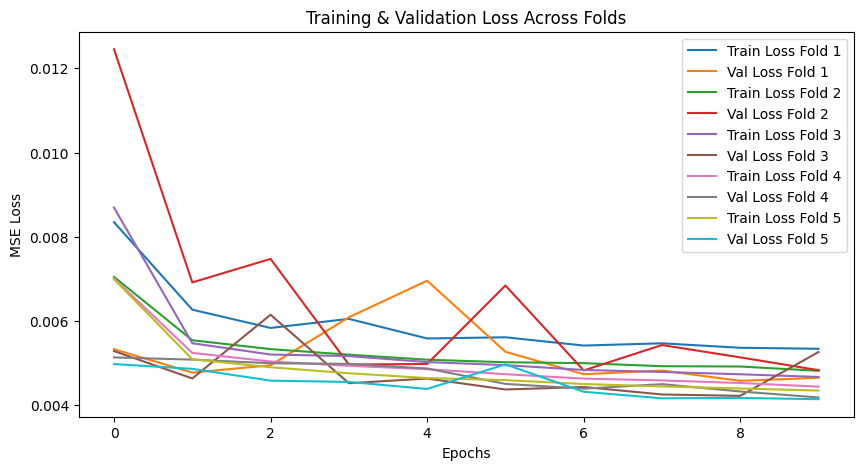

In [13]:
train_gru(build_stacked_rnn_model)

### Bidirectional

Training on fold 1...
Epoch 1/10


c:\Users\graem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0094 - mae: 0.0721 - val_loss: 0.0051 - val_mae: 0.0525
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - mae: 0.0587 - val_loss: 0.0050 - val_mae: 0.0527
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - mae: 0.0586 - val_loss: 0.0052 - val_mae: 0.0534
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - mae: 0.0571 - val_loss: 0.0055 - val_mae: 0.0550
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - mae: 0.0558 - val_loss: 0.0050 - val_mae: 0.0520
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - mae: 0.0552 - val_loss: 0.0048 - val_mae: 0.0508
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - mae: 0.0564 - val_loss: 0.0047 - val_mae: 0.0498
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - mae: 0.0555 - val_loss: 0.0050 - val_mae: 0.0522
Epoch 9/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 

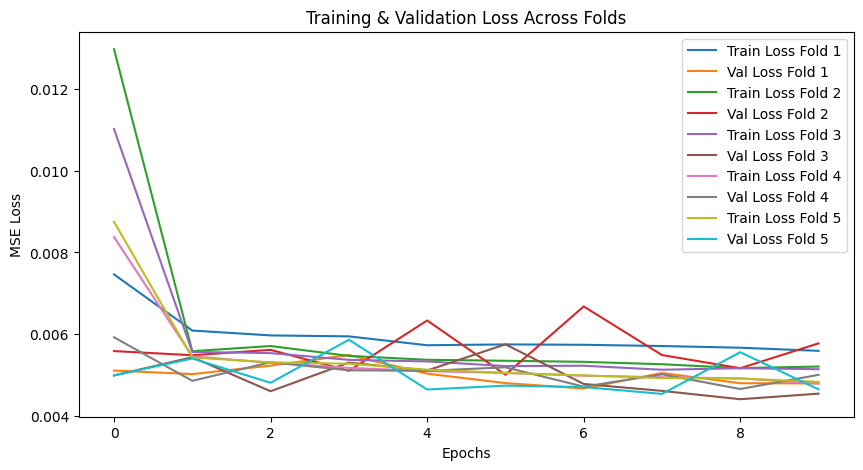

In [17]:
train_gru(build_bidirectional_rnn_model)

### Dropout and recurrent Drop out

In [ ]:
train_gru(build_dropout_rnn_model)

Training on fold 1...
Epoch 1/10


c:\Users\graem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


532/532 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0333 - mae: 0.1274 - val_loss: 0.0078 - val_mae: 0.0695
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0079 - mae: 0.0665 - val_loss: 0.0054 - val_mae: 0.0536
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0068 - mae: 0.0611 - val_loss: 0.0053 - val_mae: 0.0527
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0063 - mae: 0.0581 - val_loss: 0.0051 - val_mae: 0.0512
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0063 - mae: 0.0582 - val_loss: 0.0055 - val_mae: 0.0542
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0061 - mae: 0.0573 - val_loss: 0.0058 - val_mae: 0.0573
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0061 - mae: 0.0570 - val_loss: 0.0058 - val_mae: 0.0568
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0061 - mae: 0.0567 - val_loss: 0.0064 - val_mae: 0.0614
Epoch 9/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0061 